In [ ]:
from pathlib import Path

real_data_dir = Path("/mnt/DADES/home/jgarcia/lamquid/data/acquired")
gen_data_simulator_dir = Path("/mnt/DADES/home/jgarcia/CODE/6) STYLE TRANSFER/Generated Data SDXL Final Model 2")
gen_data_sdxl_dir = Path("/mnt/DADES/home/jgarcia/lamquid/data/synthetic/simulated")

real_data_paths = [
    bmp
    for folder in real_data_dir.iterdir()
    if folder.is_dir()
    for bmp in folder.glob("*")
]
gen_data_simulator_paths = [path for path in gen_data_simulator_dir.glob("*.png")]
gen_data_sdxl_paths = [path for path in gen_data_sdxl_dir.glob("*.png")]

print(f"Real data: {len(list(real_data_paths))} images")
print(f"Generated data from simulator: {len(gen_data_simulator_paths)} images")
print(f"Generated data from SDXL: {len(gen_data_sdxl_paths)} images")

In [ ]:
# Select images for evaluation
import random

num_images = min(len(real_data_paths), len(gen_data_simulator_paths), len(gen_data_sdxl_paths))

real_data_sample = random.sample(real_data_paths, num_images)
gen_data_simulator_sample = random.sample(gen_data_simulator_paths, num_images)
gen_data_sdxl_sample = random.sample(gen_data_sdxl_paths, num_images)

In [3]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # You can change the index if you have more GPUs
    print("CUDA Device Name:", torch.cuda.get_device_name(device))
    print("Memoria Total (MB):", torch.cuda.get_device_properties(0).total_memory // (1024 ** 2))
else:
    print("No CUDA device available")

CUDA Device Name: NVIDIA GeForce RTX 3090
Memoria Total (MB): 24161


## CLIP-I

In [42]:
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image

model_name = "openai/clip-vit-base-patch32"
processor = CLIPProcessor.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name)
model.to(device)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [ ]:
from tqdm import tqdm
from PIL import Image
import torch

def get_embeddings(image_paths, prompt, processor, model, device, mode="no"):
    embeddings = []
    for image_path in tqdm(image_paths, desc=f"Processing {len(image_paths)} images"):
        image = Image.open(image_path).convert("RGB")

        crop_size = (500, 300)
        image = image.crop((
            (image.width - crop_size[0]) // 2,
            (image.height - crop_size[1]) // 2,
            (image.width + crop_size[0]) // 2,
            (image.height + crop_size[1]) // 2
        ))
     
        if mode == "sd":
            # image darken
            image = image.point(lambda p: p * 0.65)
        
        inputs = processor(text=prompt, images=image, return_tensors="pt", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
            emb = outputs.image_embeds
            emb = emb / emb.norm(p=2, dim=-1, keepdim=True)  # Normalize embeddings
            embeddings.append(emb.cpu().numpy())

    return embeddings

original_prompt = "Grayscale close-up of a laser-printed label on industrial packaging."

real_data_embeddings = get_embeddings(real_data_sample, original_prompt, processor, model, device)
gen_data_simulator_embeddings = get_embeddings(gen_data_sdxl_sample, original_prompt, processor, model, device)
gen_data_sdxl_embeddings = get_embeddings(gen_data_simulator_sample, original_prompt, processor, model, device, mode="sd")

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Convert list of embeddings (each of shape (1, dim)) into a single array (n, dim)
real_data_embeddings = np.vstack(real_data_embeddings)
gen_data_simulator_embeddings = np.vstack(gen_data_simulator_embeddings)
gen_data_sdxl_embeddings = np.vstack(gen_data_sdxl_embeddings)

# Compute pairwise cosine similarities
similarity_real_vs_simulator = cosine_similarity(real_data_embeddings, gen_data_simulator_embeddings)
similarity_real_vs_sdxl = cosine_similarity(real_data_embeddings, gen_data_sdxl_embeddings)

avg_sim_real_simulator = np.mean(similarity_real_vs_simulator)
avg_sim_real_sdxl = np.mean(similarity_real_vs_sdxl)

# print(f"Average Cosine Similarity - Real vs Simulator: {avg_sim_real_simulator:.4f}")
print(f"Average Cosine Similarity - Real vs SDXL: {avg_sim_real_sdxl:.4f}")

Average Cosine Similarity - Real vs SDXL: 0.7544


# DINO

In [40]:
import torch
from PIL import Image
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from transformers import ViTImageProcessor, ViTModel

# Load DINO model
device = torch.device("cuda:0")
model_name = "facebook/dino-vitb16"
processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTModel.from_pretrained(model_name)
model.to(device)

def get_dino_embeddings(image_paths, processor, model, device, mode="no"):
    embeddings = []
    for image_path in tqdm(image_paths, desc=f"Processing {len(image_paths)} images"):
        image = Image.open(image_path).convert("RGB")
        if mode=="sd":
            image = image.point(lambda p: p * 0.65)
        inputs = processor(images=image, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
            # Use the [CLS] token as the image embedding
            emb = outputs.last_hidden_state[:, 0, :]
            emb = emb / emb.norm(p=2, dim=-1, keepdim=True)  # Normalize embeddings
            embeddings.append(emb.cpu().numpy())
    
    return embeddings

# Get embeddings for each dataset
real_data_embeddings = get_dino_embeddings(real_data_sample, processor, model, device)
gen_data_simulator_embeddings = get_dino_embeddings(gen_data_simulator_sample, processor, model, device)
gen_data_sdxl_embeddings = get_dino_embeddings(gen_data_sdxl_sample, processor, model, device, mode="sd")

# Convert list of embeddings (each of shape (1, dim)) into a single array (n, dim)
real_data_embeddings = np.vstack(real_data_embeddings)
gen_data_simulator_embeddings = np.vstack(gen_data_simulator_embeddings)
gen_data_sdxl_embeddings = np.vstack(gen_data_sdxl_embeddings)

# Compute pairwise cosine similarities
similarity_real_vs_simulator = cosine_similarity(real_data_embeddings, gen_data_simulator_embeddings)
similarity_real_vs_sdxl = cosine_similarity(real_data_embeddings, gen_data_sdxl_embeddings)

avg_sim_real_simulator = np.mean(similarity_real_vs_simulator)
avg_sim_real_sdxl = np.mean(similarity_real_vs_sdxl)

print(f"Average Cosine Similarity - Real vs Simulator (DINO): {avg_sim_real_simulator:.4f}")
print(f"Average Cosine Similarity - Real vs SDXL (DINO): {avg_sim_real_sdxl:.4f}")

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Processing 462 images: 100%|██████████| 462/462 [00:06<00:00, 75.30it/s]


Average Cosine Similarity - Real vs Simulator (DINO): 0.6935
Average Cosine Similarity - Real vs SDXL (DINO): 0.7490


# Noise Pattern - Fourier Transform

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from pathlib import Path

def load_and_preprocess(image_paths):
    images = []
    for path in image_paths:
        img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)  # Force grayscale
        if img is None:
            continue
        img = img.astype(np.float32) / 255.0  # Normalize to [0, 1]
        images.append(img)
    return np.array(images)

# Example usage:
real_images = load_and_preprocess(real_data_sample)
gen_simulator_images = load_and_preprocess(gen_data_simulator_sample)
gen_sdxl_images = load_and_preprocess(gen_data_sdxl_sample)

In [16]:
def compute_fft_spectrum(images):
    spectra = []
    for img in images:
        fft = np.fft.fft2(img)  # Compute FFT
        fft_shift = np.fft.fftshift(fft)  # Shift zero-frequency to center
        magnitude = np.log(np.abs(fft_shift) + 1e-9)  # Log-scale for visibility
        spectra.append(magnitude)
    return np.array(spectra)

# Compute spectra for each dataset
real_spectra = compute_fft_spectrum(real_images)
gen_simulator_spectra = compute_fft_spectrum(gen_simulator_images)
gen_sdxl_spectra = compute_fft_spectrum(gen_sdxl_images)

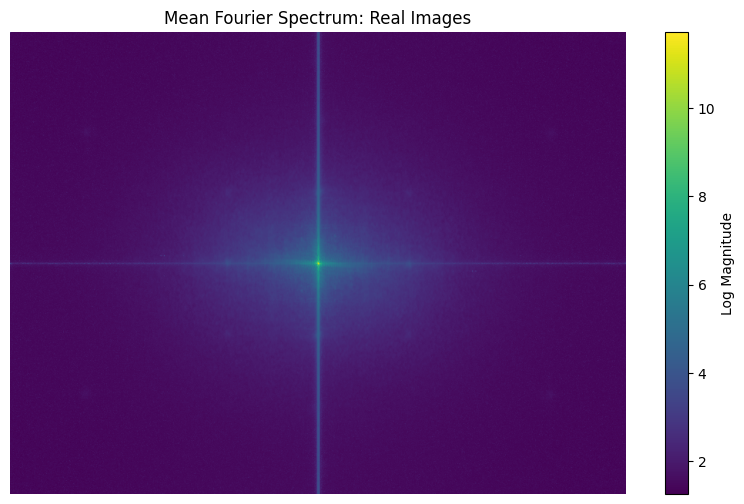

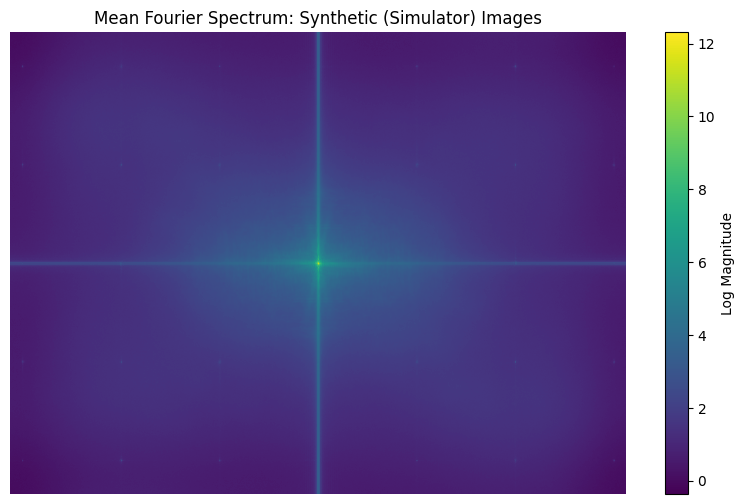

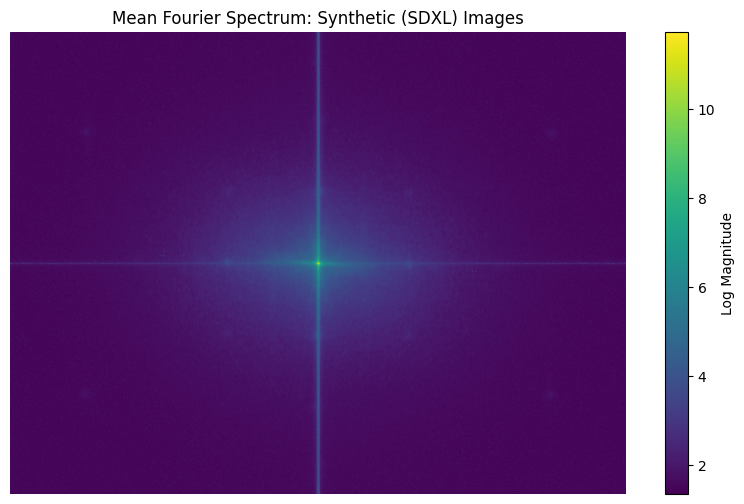

In [17]:
def plot_mean_spectrum(spectra, title):
    mean_spectrum = np.mean(spectra, axis=0)
    plt.figure(figsize=(10, 6))
    plt.imshow(mean_spectrum, cmap='viridis')
    plt.colorbar(label='Log Magnitude')
    plt.title(f'Mean Fourier Spectrum: {title}')
    plt.axis('off')
    plt.show()

plot_mean_spectrum(real_spectra, 'Real Images')
plot_mean_spectrum(gen_simulator_spectra, 'Synthetic (Simulator) Images')
plot_mean_spectrum(gen_sdxl_spectra, 'Synthetic (SDXL) Images')

In [18]:
def compute_high_freq_energy(spectra, radius=20):
    h, w = spectra.shape[1], spectra.shape[2]
    center_y, center_x = h // 2, w // 2
    y, x = np.ogrid[:h, :w]
    mask = (x - center_x)**2 + (y - center_y)**2 > radius**2  # High-pass filter
    energy = np.mean([np.sum(spectrum[mask]) for spectrum in spectra])
    return energy

print("High-frequency energy (Real):", compute_high_freq_energy(real_spectra))
print("High-frequency energy (Simulator):", compute_high_freq_energy(gen_simulator_spectra))
print("High-frequency energy (SDXL):", compute_high_freq_energy(gen_sdxl_spectra))

High-frequency energy (Real): 849203.8276529482
High-frequency energy (Simulator): 674105.6636650034
High-frequency energy (SDXL): 863741.0091297698
